In [1]:
import csv
import numpy as np
import collections
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import log
%matplotlib inline 
import sys
path = "/Users/NanditaD/Intern/mhclearn/"
sys.path.append(path+'/py/')

In [2]:
filename = 'conv_2009_allmetrics_20000'
metrics = collections.defaultdict(dict)
columns = ['AUC', 'ACC', 'PRE', 'REC', 'F1']
with open(filename, 'rb') as csvfile:
    reader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    for row in reader:
        for idx,name in enumerate(columns):
            try:
                metrics[int(row[0])][name] += float(row[idx+1])
            except:
                metrics[int(row[0])][name] = float(row[idx+1])
                
df = pd.DataFrame(metrics)/5

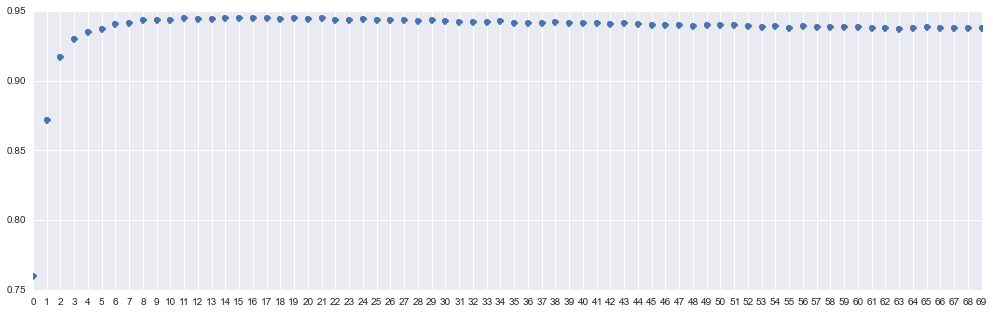

In [3]:
plt.figure(figsize=(17,5))
plt.xticks(np.arange(70))
plt.plot(np.arange(70),df.loc['AUC'],'o')

In [4]:
np.corrcoef(df.loc['F1']*df.loc['AUC'],df.loc['ACC'])

array([[ 1.        ,  0.99582168],
       [ 0.99582168,  1.        ]])

In [16]:
import sys
path = "/Users/NanditaD/Intern/mhclearn/"
sys.path.append(path+'/py/')
from pan_allele.feedforward_models import ffn_matrix
from pan_allele.convolution_model import convolution_graph_matrix
from pan_allele.generate_pseudo_sequences import create_fasta_file
from pan_allele.pan_allele_data_helpers import load_allele_sequence_data
from pan_allele.sequence_encoding import padded_indices
from pan_allele.amino_acid import amino_acid_letter_indices, amino_acid_letters
from keras.models import Graph
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score
import numpy as np
import collections
import pandas as pd
import csv


In [22]:

log_transformed_ic50_cutoff = 1 - np.log(500)/np.log(20000)

def averages(d,num):
    for key, value in d.items():
        d[key] = value / num
    return d


def format_peptide(peptide):
    if(len(peptide) == 9):
        return [peptide]
    elif(len(peptide) == 8):
        peptides = [peptide[:pos] +char +peptide[(pos):] for pos in range(4,9) for char in amino_acid_letters]
    elif(len(peptide) == 10):
        peptides = [peptide[:pos] + peptide[(pos+1):] for pos in range(4,9)]
    elif(len(peptide) == 11):
        peptides = [peptide[:pos] + peptide[(pos+2):] for pos in range(4,9)]
    return peptides
#hyperparameters  = {'cutoff':[ 0], 'dropouts': [ 0.17621593,  0.        ,  0.   ], 'sizes': [ 16, 128,  99, 128, 102], 'mult_size': [32, 15]}
hyperparameters = {'filter_length': [3, 4], 'nb_filter': [67, 92], 'mult_size': [32, 10], 'layer_size': [ 128, 92, 65]}
create_fasta_file(path, remove_residues = False, consensus_cutoff =0)
mhc_sequence_fasta_file = path + 'py/pan_allele/files/pseudo/pseudo_sequences.fasta'
allele_sequence_data, max_allele_length = load_allele_sequence_data(mhc_sequence_fasta_file)



In [ ]:
for num in range(13,18):
    #graph = ffn_matrix( hyperparameters=hyperparameters, maxlen_mhc = max_allele_length)
    graph = convolution_graph_matrix(
                                        hyperparameters = hyperparameters,
                                        maxlen_mhc = max_allele_length,
                                    )
    graph.load_weights(path + 'py/pan_allele/weights/weights_conv' + str(num))
    predictors = ['mhcflurry', 'netmhcpan', 'netmhc', 'smmpmbec_cpp']
    AUC_total = {}
    ACC_total = {}
    F1_total = {}
    total =0
    for val in predictors:
        AUC_total[val] = 0
        ACC_total[val] = 0
        F1_total[val] = 0

    allele_list = ['A0101',	    'A0201',	    'A0202',	    'A0203',	    'A0206',	    'A0301',	    'A1101',	    'A2301',	    'A2402',	    'A2501',	    'A2601',
'A2602',	'A2603',	'A2902',	'A3001',	'A3002',	'A3101',	'A3201',	'A3301',	'A6801',	'A6802',	'A6901',
'A8001',	'B0702',	'B0801',	'B0802',	'B0803',	'B1501',	'B1503',	'B1509',	'B1517',	'B1801',	'B2703',
'B2705',	'B3501',	'B3801',	'B3901',	'B4001',	'B4002',	'B4402',	'B4403',	'B4501',	'B4601',	'B5101',
'B5301',	'B5401',	'B5701',	'B5801'								]
    for allele in allele_list:
        filename = 'combined-test-data/'+ allele + '.csv'
        predictions = collections.defaultdict(dict)
        with open(filename, 'rb') as csvfile:
            records = csv.reader(csvfile, quoting=csv.QUOTE_NONE)
            header = records.next()
            for row in records:
                    for i,val in enumerate(header):
                        try:
                            predictions[row[0]][val] = float(row[i])
                        except:
                            pass
        peptides = predictions.keys()
        mhc_seq = padded_indices([allele_sequence_data[allele]],
                                        add_start_symbol=False,
                                        add_end_symbol=False,
                                        index_dict=amino_acid_letter_indices)
        for peptide in peptides:
            mhc_seq = padded_indices([allele_sequence_data[allele]],
                                            add_start_symbol=False,
                                            add_end_symbol=False,
                                            index_dict=amino_acid_letter_indices)
            X_p = padded_indices(format_peptide(peptide),
                                    add_start_symbol=False,
                                    add_end_symbol=False,
                                    index_dict=amino_acid_letter_indices)
            mhc_seq = np.tile(mhc_seq,(len(X_p),1))
            preds = graph.predict({'peptide':X_p,'mhc':mhc_seq})['output']
            preds = np.mean(preds)
            value =  20000**(1- preds)
            predictions[peptide]['mhcflurry'] = float(value)
            #print peptide, predictions[peptide]['meas'], value

        df_pred = pd.DataFrame(predictions)
        Y_true = np.array(df_pred.loc['meas'])
        Y_true_binary = Y_true <=500
        print "\n=====", allele, sum(Y_true_binary), len(Y_true), "===="
        total += len(peptides)
        for val in predictors:
            Y_pred = np.array(df_pred.loc[val])
            Y_pred_log = 1 - np.log(Y_pred)/np.log(20000)
            try:
                AUC = roc_auc_score(Y_true_binary, Y_pred_log)
                Y_pred_binary = Y_pred <= 500
                ACC = accuracy_score(Y_true_binary, Y_pred_binary)
                F1 = f1_score(Y_true_binary, Y_pred_binary)
                print ">",val
                print 'AUC=', AUC,'\tACC=', ACC,'\tF1=', F1,
                print "\tprecision=", precision_score(Y_true_binary, Y_pred_binary)
                print "\trecall=", recall_score(Y_true_binary, Y_pred_binary)
                AUC_total[val] += AUC*len(peptides)
                ACC_total[val] += ACC*len(peptides)
                F1_total[val] += F1*len(peptides)
            except:
                pass
    print num
    print averages(AUC_total, total)
    print averages(ACC_total, total)
    print averages(F1_total, total)

